In [1]:
"""
This Program Evaluates and Predicts O-PPAC data using a Support Vector Regression
@author: Ted Yoo
"""

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
# Takes (9,132,1011) dataset from Yassid and compiles it into a (9099,132) set.
def data_compile(histdata, x_pos):
    data = []
    labels = []
    for i in range(histdata.shape[0]):
        #Starts at 1 because first event of each x-position has no charge recorded.
        for j in range(1,histdata.shape[2]):
            data.append(histdata[i,0:132,j])
            labels.append(x_pos[i])
    return(np.array(data),np.array(labels))

In [3]:
#Scales Train and Test based on specified scaler_type
def TT_scaler(scaler_type, train, test):
    scaler_type.fit(train)
    train = scaler_type.transform(train)
    test = scaler_type.transform(test)
    return (train, test)

In [4]:
#Train SVR Model and Predict 
def SVR_Model(train_data, train_labels, test_data):
    Model = SVR()
    Model.fit(train_data, train_labels.ravel())
    predictions = Model.predict(test_data)
    return predictions

In [8]:
def main():
    #Extract data from h5 file
    dataset = h5py.File('simu_HDF_new.h5', 'r')
    num_diodes = dataset['Num_diodes'][...]
    x_pos = (dataset['Xpos'][...])/100
    y_pos = dataset['Ypos'][...]
    histgrid = dataset['histgrid'][...]
    dataset.close()
    
    #Defines Scalers used to scale inputs and outputs
    input_scaler = MinMaxScaler()
    output_scaler = StandardScaler()
   
    #Put Compile all data and their labels
    all_data, all_labels = data_compile(histgrid, x_pos)

    #Split Train, Validation and Test datasets
    train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size = 0.3, shuffle = True)

    #Reshape Labels for Scaling
    train_labels = train_labels.reshape(-1,1)
    test_labels = test_labels.reshape(-1,1)

    #Scale both Inputs and Outputs
    train_data, test_data = TT_scaler(input_scaler, train_data, test_data)
    train_labels, test_labels = TT_scaler(output_scaler, train_labels, test_labels)
    
    #Make predictions from SVR Model
    predictions = SVR_Model(train_data, train_labels, test_data)
    
    #Inverse Transform scaled Labels and Predictions
    test_rescale_labels = output_scaler.inverse_transform(test_labels)
    predictions_rescale = output_scaler.inverse_transform(predictions)
    
    #Get Mean Absolute Error and Mean Square Error
    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    print("mean absolute error = "+ str(mae) + " mean square error = "+ str(mse))
    
    #Plot Predictions vs True Values
    a = plt.axes(aspect='equal')
    plt.scatter(test_rescale_labels, predictions_rescale)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    lims = [-50, 50]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    plt.title("SVR O-PPAC Predictions vs True Values")

mean absolute error = 0.05290403577562493 mean square error = 0.0054661938400175246


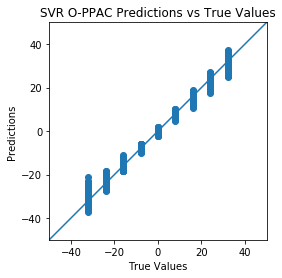

In [9]:
if __name__ == "__main__":
    main()